# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Load Dataset

In [ ]:
# To be run if the files are in your computer

import pandas as pd
import numpy as np

# drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'
# Cebrina's   Path: C:\Users\cebri\Documents\Wind Power Estimation\Data
# Guillermo's Path: C:\DTU\\02456 - Deep Learning\Project\Datasets
# Tomi's      Path: C:\Users\PC\Documents\GitHub\WindPower_Estimation

dataPath = r'C:\DTU\\02456 - Deep Learning\Project\Datasets'

dataset_train_1 = pd.read_csv(dataPath+'\Case1\Dataset_Train_1_new.csv', )
dataset_test_1 = pd.read_csv(dataPath+'\Case1\Dataset_Test_1_new.csv')

dataset_train_1.head()

,Date_Time,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m,Park_Power_[KW]
0,2017-01-07 20:15:00,0.476323,0.110000,0.218502,0.782227,0.752212,0.473538,0.127679,0.218502,0.752212,0.484680,0.047716,0.218502,0.752212,0.515320,0.019504,0.218502,0.752212,0.690394
1,2017-01-07 20:30:00,0.479109,0.116923,0.214832,0.781496,0.755162,0.479109,0.135714,0.214832,0.755162,0.473538,0.053299,0.214832,0.755162,0.459610,0.024823,0.214832,0.755162,0.690394
2,2017-01-07 20:45:00,0.481894,0.127692,0.211009,0.780216,0.758112,0.481894,0.147321,0.211009,0.758112,0.462396,0.061421,0.211009,0.758112,0.431755,0.032624,0.211009,0.758112,0.690394
3,2017-01-07 21:00:00,0.484680,0.140769,0.207187,0.778387,0.764012,0.487465,0.161607,0.207187,0.764012,0.459610,0.072589,0.207187,0.764012,0.417827,0.042908,0.207187,0.764012,0.690394
4,2017-01-07 21:15:00,0.487465,0.155385,0.203364,0.776376,0.766962,0.490251,0.178571,0.203364,0.766962,0.456825,0.084772,0.203364,0.766962,0.412256,0.054610,0.203364,0.766962,0.690394


In [1]:
# To be run if the files are in Google Colab

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'

dataset_train_1 = pd.read_csv(drive_path+'Dataset_Train_1_new.csv')
dataset_test_1 = pd.read_csv(drive_path+'Dataset_Test_1_new.csv')

dataset_train_1.head()

Mounted at /content/drive


,Date_Time,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m,Park_Power_[KW]
0,2017-01-07 20:15:00,0.476323,0.110000,0.218502,0.782227,0.752212,0.473538,0.127679,0.218502,0.752212,0.484680,0.047716,0.218502,0.752212,0.515320,0.019504,0.218502,0.752212,0.690394
1,2017-01-07 20:30:00,0.479109,0.116923,0.214832,0.781496,0.755162,0.479109,0.135714,0.214832,0.755162,0.473538,0.053299,0.214832,0.755162,0.459610,0.024823,0.214832,0.755162,0.690394
2,2017-01-07 20:45:00,0.481894,0.127692,0.211009,0.780216,0.758112,0.481894,0.147321,0.211009,0.758112,0.462396,0.061421,0.211009,0.758112,0.431755,0.032624,0.211009,0.758112,0.690394
3,2017-01-07 21:00:00,0.484680,0.140769,0.207187,0.778387,0.764012,0.487465,0.161607,0.207187,0.764012,0.459610,0.072589,0.207187,0.764012,0.417827,0.042908,0.207187,0.764012,0.690394
4,2017-01-07 21:15:00,0.487465,0.155385,0.203364,0.776376,0.766962,0.490251,0.178571,0.203364,0.766962,0.456825,0.084772,0.203364,0.766962,0.412256,0.054610,0.203364,0.766962,0.690394


## Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

In [3]:
training_set_x = dataset_train_1[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
training_set_y = dataset_train_1[['Park_Power_[KW]']]

test_set_x = dataset_test_1[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
test_set_y = dataset_test_1[['Park_Power_[KW]']]

#Transforming to normal arrays
training_set_x = training_set_x.values
test_set_x = test_set_x.values

training_set_y = training_set_y.values
test_set_y = test_set_y.values

## Dataloading

In [4]:
# Checking if CUDA (GPU) is available

cuda_available = torch.cuda.is_available()
print("Running GPU.") if cuda_available else print("No GPU available.")

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if cuda_available:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if cuda_available:
        return x.cpu().data.numpy()
    return x.data.numpy()

# Empty CUDA cache, just in case
import gc
gc.collect()
torch.cuda.empty_cache()

Running GPU.


In [5]:
# This function is a manual implementation, similar to other implementations like TimeSeriesData

def sliding_windows(data_x, data_y, seq_length_past, seq_length_future):
    x = []
    y = []

    for i in range(seq_length_past,len(data_x)-seq_length_future+1):
        _x = data_x[(i-seq_length_past):(i+seq_length_future)]
        _y = data_y[i]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# Length of sequences to be fed into NN is defined here

# seq_length_past = 99 means the last 99 timesteps are included in the sequence
# seq_length_future = 1 means the current timestep is included in the sequence (>1 also includes future timesteps)
seq_length_past = 99
seq_length_future = 1

# Assembling sequences for training set
x, y = sliding_windows(training_set_x, training_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  trainX = torch.Tensor(np.array(x)).cuda()
  trainY = torch.Tensor(np.array(y)).cuda()
else:
  trainX = torch.Tensor(np.array(x))
  trainY = torch.Tensor(np.array(y))

# Assembling sequences for test set
x, y = sliding_windows(test_set_x, test_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

## Model

In [6]:
# Definition of the network
# Maybe a name like "Net" instead of "LSTM" would be more appropriate

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        if cuda_available:
          h_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size).cuda())
          c_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size).cuda())
        else:
          h_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size))
          c_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)
        out = self.sigmoid(out)

        return out

In [7]:
# Defining training settings

num_epochs = 300
learning_rate = 1e-3
batch_size = 1000

input_size = trainX.shape[2]    #number of features
hidden_size = 20                #number of hidden units
num_layers = 1                  #number of LSTM layers

num_classes = 1

if cuda_available:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers).cuda()
else:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# Using MSE Loss and Adam, as all papers using LSTM seem to use this
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Moving sequences into data loader

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_loader = DataLoader(dataset=TensorDataset(trainX,trainY),batch_size=batch_size,shuffle=True)

In [8]:
# Training the model

lstm.train()
for epoch in range(num_epochs+1):
    train_losses = []

    for x_batch, y_batch in train_loader:
        outputs = lstm(x_batch)

        # obtain the loss function
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    if epoch % 50 == 0:   # Reporting results from time to time to track learning progress
        print("Epoch: %d, loss: %1.5f" % (epoch, np.mean(train_losses)))

Epoch: 0, loss: 0.09407
Epoch: 50, loss: 0.03650
Epoch: 100, loss: 0.03405
Epoch: 150, loss: 0.03306
Epoch: 200, loss: 0.03180
Epoch: 250, loss: 0.03175
Epoch: 300, loss: 0.03375


## Testing for Park Power values

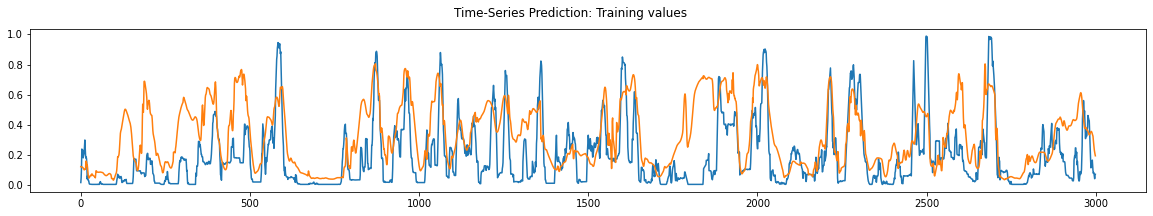

Loss:  0.03233982824723092


In [9]:
# Plotting fitted training values

lstm.eval()
train_predict = lstm(trainX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  train_predict = train_predict.cpu()

# Calculating loss of fitted training data
loss = criterion(train_predict[:,0], torch.tensor(training_set_y[:,0][seq_length_past:]))

train_predict = train_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,train_predict))

# Set here the start and end index of data in order to zoom in
start_index = 2000
end_index = 5000

dataY_plot = training_set_y[start_index:end_index]
data_predict = train_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

# Uncommenting the below will also plot Speeds and Directions to compare with already plotted curves
#for i in range(input_size):
#  plt.plot(np.transpose([np.transpose(training_set_x[:,i])])[start_index:end_index],',')

plt.suptitle('Time-Series Prediction: Training values')
plt.show()

# Printing loss below the plot
print('Loss: ',loss.item())

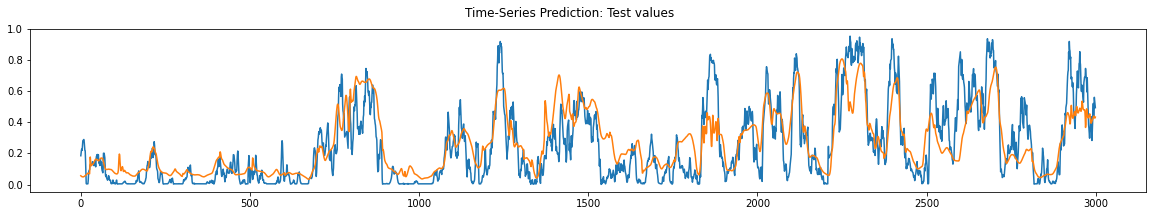

Loss:  0.03236965759183028


In [10]:
# Plotting predicted test values

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

# Calculating loss of predicted test data
loss = criterion(test_predict[:,0], torch.tensor(test_set_y[:,0][seq_length_past:]))

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = 12000
end_index = 15000

dataY_plot = test_set_y[start_index:end_index]
data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

# Uncommenting the below will also plot Speeds and Directions to compare with already plotted curves
#for i in range(input_size):
#  plt.plot(np.transpose([np.transpose(test_set_x[:,i])])[start_index:end_index],',')

plt.suptitle('Time-Series Prediction: Test values')
plt.show()

# Printing loss below the plot
print('Loss: ',loss.item())